In [1]:
import EXOSIMS
import EXOSIMS.MissionSim
import os.path
import numpy as np
import jason
import EXOSIMS.SimulatedUniverse.SAG13Universe
import EXOSIMS.SimulatedUniverse.KeplerLikeUniverse
import matplotlib.pyplot as plt
from astropy.visualization import quantity_support
from EXOSIMS.StarCatalog import EXOCAT1
from astropy import units as u

#reset config of plots
SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 17

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#astropy quantity support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x1aeff3b6ba8>

In [2]:
#setup simulation
#a detailed describition is in readme.pdf
specs = {"modules": {
      "PlanetPopulation": "KeplerLike2",
      "StarCatalog": "EXOCAT1",
      "OpticalSystem": "Nemati",
      "ZodiacalLight": "Stark",
      "BackgroundSources": " ",
      "PlanetPhysicalModel": "FortneyMarleyCahoyMix1",
      "PostProcessing": " ",
      "Completeness": " ",
      "TargetList": " ",
      "SimulatedUniverse": " KeplerLikeUniverse"},
      "scienceInstruments": [{ "name": "imager"}],
      "starlightSuppressionSystems": [{ "name": "coronagraph"}],
      "explainFiltering": True}

In [3]:
#instantiate all modules
SU = EXOSIMS.SimulatedUniverse.KeplerLikeUniverse.KeplerLikeUniverse(**specs)

Imported TargetList (prototype module) from EXOSIMS.Prototypes.TargetList
Imported EXOCAT1 (specific module) from EXOSIMS.StarCatalog.EXOCAT1
Imported Nemati (specific module) from EXOSIMS.OpticalSystem.Nemati
Imported Stark (specific module) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype module) from EXOSIMS.Prototypes.PostProcessing
Imported BackgroundSources (prototype module) from EXOSIMS.Prototypes.BackgroundSources
Imported Completeness (prototype module) from EXOSIMS.Prototypes.Completeness
Imported KeplerLike2 (specific module) from EXOSIMS.PlanetPopulation.KeplerLike2
Imported FortneyMarleyCahoyMix1 (specific module) from EXOSIMS.PlanetP[...]el.FortneyMarleyCahoyMix1
2396 targets imported from star catalog.
2089 targets remain after nan filtering.
1985 targets remain after binary filter.
1985 targets remain after IWA filter.
1985 targets remain after integration time cutoff filter.
1985 targets remain after completeness filter.


In [5]:
print(SU.TargetList.Spec)
print(SU.TargetList.nStars)
print(SU.nPlans)
print(SU.plan2star)

[b'K2V' b'M1' b'G9V' ... b'K3/4V' b'G8V' b'']
1985


### Mass distribution of planets

In [7]:
#define the masses of all planets
#mass in earth mass
masses = SU.Mp

#convert spec object array to string array
Spec=SU.TargetList.Spec.astype(str)

#assign each palent a spec type
planet_spec = np.array([Spec[i] for i in SU.plan2star])

In [8]:
#for i in Mspec, if == 0 then means it contains str 'M'
#in other word, its M-type
strM = 'M' 
Mspec = []
for s in planet_spec:
    M = s.find(strM)
    Mspec.append(M)

#convert to array
Mspec = np.array(Mspec)
#get the index of all the planets around M stars
M_id = np.where(Mspec==0)

#use the indexing to extract mass for all the planets around M stars
M_mass = [masses[i] for i in M_id][0]

M_len = len(M_mass)
print(len(M_mass))

2340


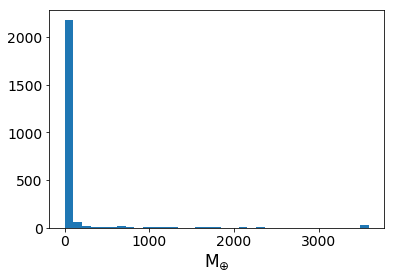

In [9]:
hist, Mbins, _ = plt.hist(M_mass, bins=35)

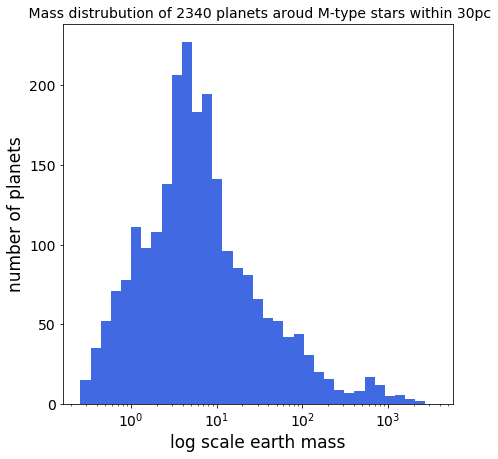

In [10]:
plt.figure(figsize=(7,7))

Mlogbins = np.logspace(np.log10(Mbins[0]),np.log10(Mbins[-1]),len(Mbins))
plt.hist(M_mass,bins=Mlogbins,color="royalblue")
plt.gca().set_xscale("log")

plt.xlabel('log scale earth mass')
plt.ylabel('number of planets')
plt.title(' Mass distrubution of %d planets aroud M-type stars within 30pc' %M_len)

plt.savefig('M-type.png')

In [11]:
#for i in FGKspec, if == 0 then means it contains str 'F'
#in other word, its F-type
strF = 'F'
strG = 'G'
strK = 'K'
FGKspec = []
for s in planet_spec:
    F = s.find(strF)
    G = s.find(strG)
    K = s.find(strK)
    FGKspec.append(F&G&K)

#convert to array
FGKspec = np.array(FGKspec)
#get the index of all the planets around FGK stars
FGK_id = np.where(FGKspec==0)

#use the indexing to extract mass for all the planets around FGK stars
FGK_mass = [masses[i] for i in FGK_id][0]

FGK_len = len(FGK_mass)
print(len(FGK_mass))

4767


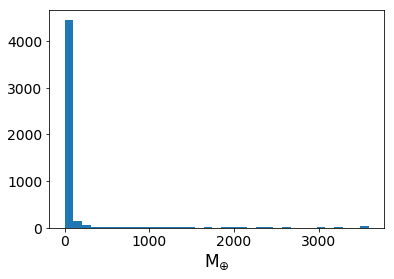

In [12]:
hist, FGKbins, _ = plt.hist(FGK_mass, bins=35)

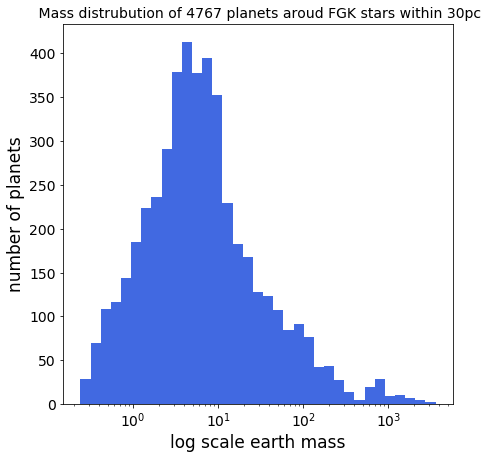

In [13]:
plt.figure(figsize=(7,7))
FGKlogbins = np.logspace(np.log10(FGKbins[0]),np.log10(FGKbins[-1]),len(FGKbins))
plt.hist(FGK_mass,bins=FGKlogbins,color="royalblue")
#plt.xlim(0,10000)
plt.gca().set_xscale("log")

plt.xlabel('log scale earth mass')
plt.ylabel('number of planets')
plt.title(' Mass distrubution of %d planets aroud FGK stars within 30pc'%FGK_len)

plt.savefig('FGK-type.png')

## Tempeture of planets

In [16]:
#define some variables
star_name = SU.TargetList.Name.astype(str)
star_mag = SU.TargetList.MV
albedo = SU.p

#star luminsity in terms of ln(sun lum)
star_lum = SU.TargetList.L

#define distance of the planets form their host star
d = SU.d
dist = d.to(u.m)

#define solar luministy in terms of watt
solar_lum = 3.828E26

#change the lum unit to Watt
star_lum_W = []
for i in star_lum:
    lum = solar_lum*(np.e**i)
    star_lum_W.append(lum)
    
#assign each palent the lum of its star
planet_star_lum = np.array([star_lum_W[i] for i in SU.plan2star])

#extract the planets around FGK stars for their corresponding star lum
FGKstar_lum = [planet_star_lum[i] for i in FGK_id][0]
Mstar_lum = [planet_star_lum[i] for i in M_id][0]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in double_scalars


In [17]:
#use the indexing to extract distant adn albedo for all the planets around FGK stars
FGK_dist = [dist[i] for i in FGK_id][0]
FGK_albedo = [albedo[i] for i in FGK_id][0]

#use the indexing to extract distant adn albedo for all the planets around M stars
M_dist = [dist[i] for i in M_id][0]
M_albedo = [albedo[i] for i in M_id][0]

#### Temp for planets around FGK stars

In [18]:
#define Stefan-Boltzman constant
sigma = 5.6704E-8

#caculate the tempurature in K
FGK_T = np.power((1-FGK_albedo)*FGKstar_lum/(16.*np.pi*(FGK_dist**2.)*sigma),1./4)
#change astropy unit to floats
FGK_Temp = FGK_T.value

#limt the range of the temperature to get rid of the extremes
Temp_FGK = []
for i in FGK_Temp:
    if i < 2500:
        Temp_FGK.append(i)

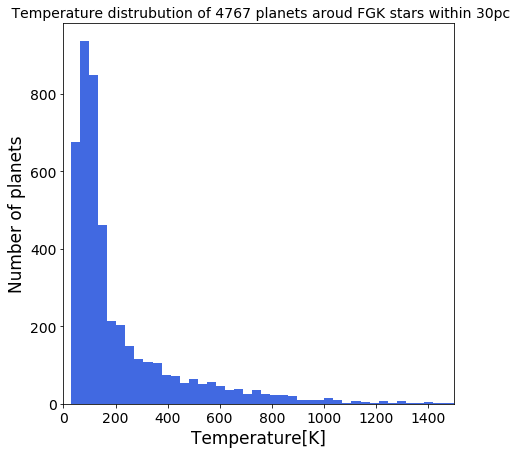

In [19]:
plt.figure(figsize=(7,7))

hist, FGK_Tbins, _ = plt.hist(Temp_FGK, bins=70,color="royalblue")
plt.xlim(0,1500)
plt.xlabel('Temperature[K]')
plt.ylabel('Number of planets')
plt.title(' Temperature distrubution of %d planets aroud FGK stars within 30pc'%FGK_len)

plt.savefig('FGK-T.png')

Text(0.5,1,' Tempurature distrubution of 4767 planets aroud FGK type star within 30pc')

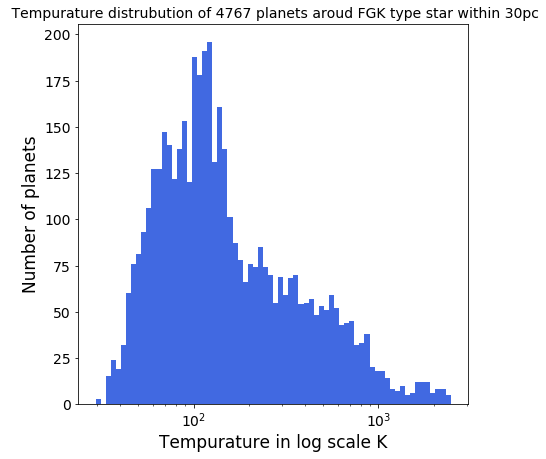

In [22]:
plt.figure(figsize=(7,7))

FGK_Tlogbins = np.logspace(np.log10(FGK_Tbins[0]),np.log10(FGK_Tbins[-1]),len(FGK_Tbins))
plt.hist(Temp_FGK,bins=FGK_Tlogbins,color="royalblue")
plt.gca().set_xscale("log")

plt.xlabel('Tempurature in log scale K')
plt.ylabel('Number of planets')
plt.title(' Tempurature distrubution of %d planets aroud FGK type star within 30pc'%FGK_len)

#### Temp for planets around FGK stars

In [23]:
#caculate the tempurature in K
M_T = np.power((1-M_albedo)*Mstar_lum/(16.*np.pi*(M_dist**2.)*sigma),1./4)
#change astropy unit to floats
M_Temp = M_T.value

#limt the range of the temperature to get rid of the extremes
Temp_M = []
for i in M_Temp:
    if i < 2500:
        Temp_M.append(i)

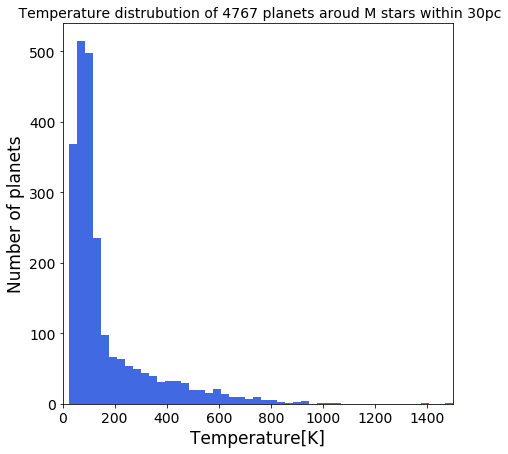

In [24]:
plt.figure(figsize=(7,7))

hist, M_Tbins, _ = plt.hist(Temp_M, bins=70,color="royalblue")
plt.xlim(0,1500)
plt.xlabel('Temperature[K]')
plt.ylabel('Number of planets')
plt.title(' Temperature distrubution of %d planets aroud M stars within 30pc'%FGK_len)

plt.savefig('M-T.png')

Text(0.5,1,' Tempurature distrubution of 2340 planets aroud M type star within 30pc')

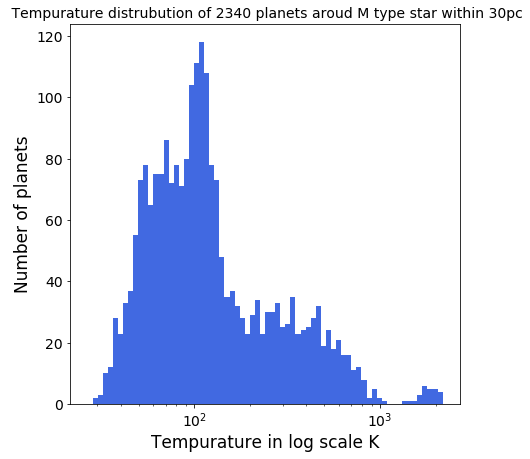

In [25]:
plt.figure(figsize=(7,7))

M_Tlogbins = np.logspace(np.log10(M_Tbins[0]),np.log10(M_Tbins[-1]),len(M_Tbins))
plt.hist(Temp_M,bins=M_Tlogbins,color="royalblue")
plt.gca().set_xscale("log")

plt.xlabel('Tempurature in log scale K')
plt.ylabel('Number of planets')
plt.title(' Tempurature distrubution of %d planets aroud M type star within 30pc'%M_len)